<a href="https://colab.research.google.com/github/shpark02084/TensorFlow/blob/main/timeseries_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Try to build a deep learning model to predict the price of Bitcoin





Following Steps

* Get time series data (the historical price of Bitcoin: 2014-09-17 to 2022-04-29)
* Preprocess the data into a time series problem

* Build deep learning models with
  
  * Univariate Time Series
  * Multivariate Time Series

* Creating a modelling checkpoint
* Predict the time series models


In [ ]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-05276190-94dc-172e-2222-1337ddd08a0e)


## Get data

In [ ]:
pip install yfinance


In [ ]:
import yfinance as yf

In [ ]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt 
import math
from statsmodels.tsa.arima_model import ARIMA 
from sklearn.metrics import mean_squared_error, mean_absolute_error
df = yf.download('BTC-USD')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[*********************100%***********************]  1 of 1 completed


In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2022-04-25,39472.605469,40491.753906,38338.378906,40458.308594,40458.308594,35445730570
2022-04-26,40448.421875,40713.890625,37884.984375,38117.460938,38117.460938,34569088416
2022-04-27,38120.300781,39397.917969,37997.312500,39241.121094,39241.121094,30981015184


In [ ]:
# Only extract closing price for each day
bitcoin_prices = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2022-04-25,40458.308594
2022-04-26,38117.460938
2022-04-27,39241.121094


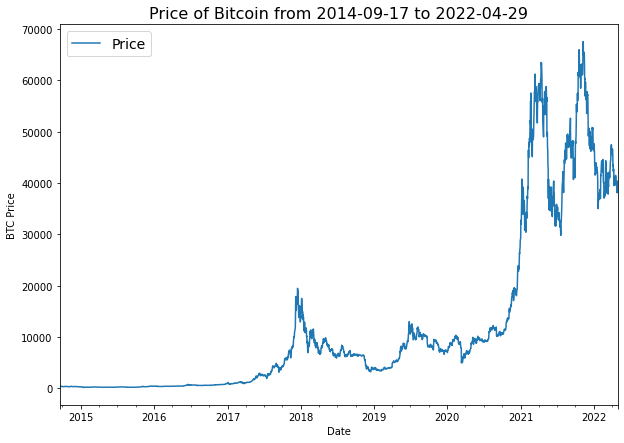

In [ ]:
# Visualize 
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 2014-09-17 to 2022-04-29", fontsize=16)
plt.legend(fontsize=14);

In [ ]:
# 80% Train, 20% Test
split_size = int(0.8 *len(df))
training_data = list(df[:split_size]['Adj Close'])
testing_data = list(df[split_size:]['Adj Close'])
len(training_data), len(testing_data)

(2225, 557)

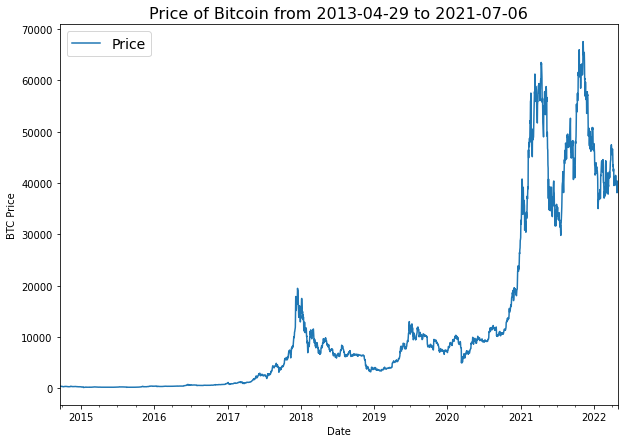

In [ ]:
# Visualize 
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 2013-04-29 to 2021-07-06", fontsize=16)
plt.legend(fontsize=14);

In [ ]:
timesteps = df.index.to_numpy()
prices = df["Adj Close"].to_numpy()
timesteps[:10], prices[:10]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
        '2014-09-23T00:00:00.000000000', '2014-09-24T00:00:00.000000000',
        '2014-09-25T00:00:00.000000000', '2014-09-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([457.33401489, 424.44000244, 394.79598999, 408.9039917 ,
        398.8210144 , 402.15200806, 435.79098511, 423.20498657,
        411.57400513, 404.42498779]))

## Split data

In [ ]:
# 80% Train, 20% Test
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2225, 557, 2225, 557)

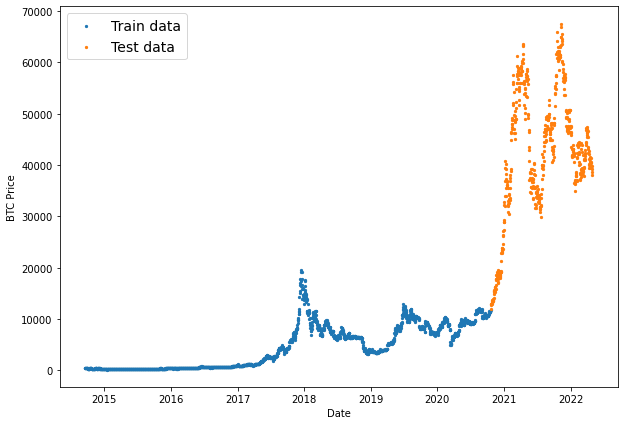

In [ ]:
# Plot split data
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):

  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

## Evaluate predictions (Error)






In [ ]:
import tensorflow as tf
import numpy as np


In [ ]:
def mean_absolute_scaled_error(y_true, y_pred):
 
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) 

  return mae / mae_naive_no_season

In [ ]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  if mae.ndim > 0: 
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

## Make a Model checkpoint

In [ ]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), 
                                            verbose=0,
                                            save_best_only=True) 

## Base Model (ARIMA)


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt 
import math
from statsmodels.tsa.arima_model import ARIMA 
from sklearn.metrics import mean_squared_error, mean_absolute_error 


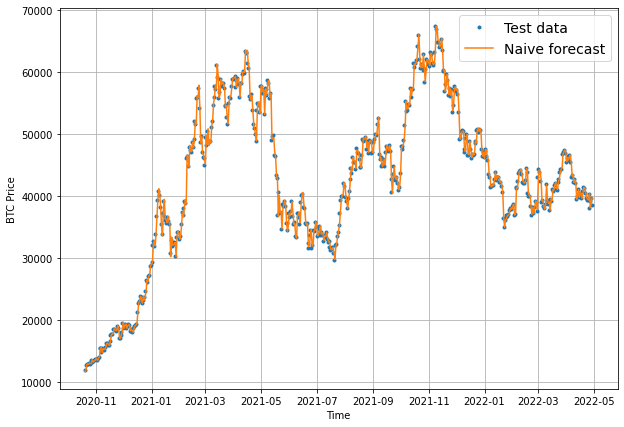

In [ ]:
#ARIMA Model
model_0_preds =[]
n = len(testing_data)
for i in range(n):
  model_0 = ARIMA(training_data, order=(4,1,0))
  model_0_fit = model_0.fit()
  output = model_0_fit.forecast()
  yhat = list(output[0])[0]
  model_0_preds.append(yhat)
  actual_test_value = testing_data[i] 
  training_data.append(actual_test_value)

plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test, values=testing_data,  label="Test data")
plot_time_series(timesteps=X_test, values=model_0_preds, format="-", label="Naive forecast");

In [ ]:
ARIMA_results = evaluate_preds(y_true=testing_data,
                               y_pred=model_0_preds)
ARIMA_results

{'mae': 1210.5464,
 'mape': 2.8948693,
 'mase': 1.0055416,
 'mse': 2868171.2,
 'rmse': 1693.5676}

# Univariate

## Model 1 (window 7, horizon 1)

In [ ]:
# Window for one week for predicting price of next day
HORIZON = 1 
WINDOW_SIZE = 7

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):

  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [ ]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2775, 2775)

In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):

  split_size = int(len(windows) * (1-test_split)) # 80% Train, 20% Test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2220, 555, 2220, 555)

In [ ]:
# MODEL 1 (Window size 7, Horizon 1)
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 2s 39ms/step - loss: 1098.5872 - mae: 1098.5872 - val_loss: 5017.1523 - val_mae: 5017.1523
Epoch 2/100
18/18 [==============================] - 0s 26ms/step - loss: 330.0732 - mae: 330.0732 - val_loss: 2357.7302 - val_mae: 2357.7302
Epoch 3/100
18/18 [==============================] - 0s 25ms/step - loss: 238.5584 - mae: 238.5584 - val_loss: 2024.1277 - val_mae: 2024.1277
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 219.1023 - mae: 219.1023 - val_loss: 2030.5448 - val_mae: 2030.5448
Epoch 5/100
18/18 [==============================] - 0s 25ms/step - loss: 213.1519 - mae: 213.1519 - val_loss: 1954.3876 - val_mae: 1954.3876
Epoch 6/100
18/18 [==============================] - 0s 25ms/step - loss: 207.7905 - mae: 207.7905 - val_loss: 1881.4768 - val_mae: 1881.4768
Epoch 7/100
18/18 [==============================] - 0s 26ms/step - loss: 200.6454 - mae: 200.6454 - val_loss: 1827.2644 - val_mae: 1827.2644
Epoch

In [ ]:
# Load model
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1218.4181 - mae: 1218.4181


[1218.4180908203125, 1218.4180908203125]

In [ ]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)
  return tf.squeeze(forecast) 

In [ ]:
# Make predictions
model_1_preds = make_preds(model_1, test_windows)


In [ ]:
# Evaluate predictions
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 1218.4181,
 'mape': 2.9109976,
 'mase': 1.0100235,
 'mse': 2889481.5,
 'rmse': 1699.8474}

## Model 2 (CNN)

In [ ]:
# MODEl 2 CNN 
HORIZON = 1 
WINDOW_SIZE = 7

In [ ]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2220, 555, 2220, 555)

In [ ]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_2_conv1D")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_2.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets wr

In [ ]:
# Load in best performing Conv1D model and evaluate it on the test data
model_2 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1229.1823


1229.1822509765625

In [ ]:
# Make predictions
model_2_preds = make_preds(model_2, test_windows)


In [ ]:
# Evaluate predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 1229.1823,
 'mape': 2.9355433,
 'mase': 1.0189465,
 'mse': 2938350.5,
 'rmse': 1714.1617}

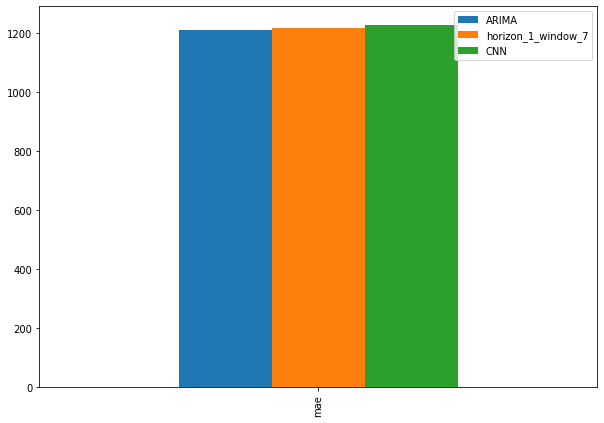

# Multivariate Time Series (Price and Block Reward Value)


##Block Reward

In [ ]:
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [ ]:
# Block Reward values 
block_reward_1 = 50 
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 =6.25

blcok_reward_1_datetime = np.datetime64("2009-01-03")
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

block_reward_1_days = (block_reward_2_datetime - bitcoin_prices.index[0]).days
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days


# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4



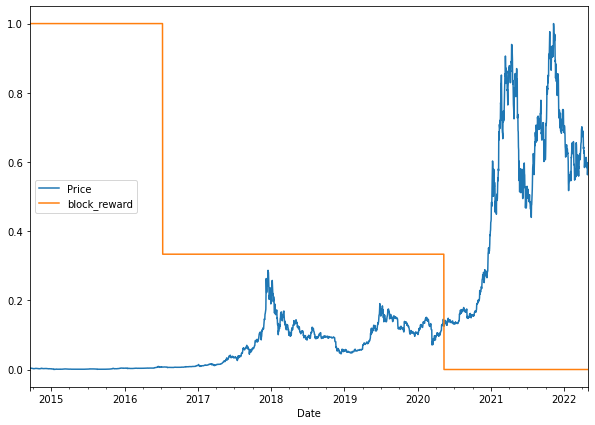

In [ ]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));


## Model 3 (window 7, horizon 1, Multivariate) 

In [ ]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,25,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,25,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,25,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,25,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,25,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,25,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,25,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,25,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


In [ ]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()


,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,25.0,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,25.0,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,25.0,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,25.0,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,25.0,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014


In [ ]:
y.head()


Date
2014-09-24    423.204987
2014-09-25    411.574005
2014-09-26    404.424988
2014-09-27    399.519989
2014-09-28    377.181000
Name: Price, dtype: float32

In [ ]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)


(2220, 2220, 555, 555)

In [ ]:
# Model 3 (Window 7 horizon 1 Multivaraite)
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense_multivariate")

# Compile
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, 
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_ex

In [ ]:
# Load best model
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense_multivariate")
model_3.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 1216.0281


1216.028076171875

In [ ]:
# Make prediction
model_3_preds = tf.squeeze(model_3.predict(X_test))


## Model 4 N-BEATS

In [ ]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.19014993  0.83798355 -0.3287001   0.2515993  -0.47540283 -0.7783665
 -0.5299447 ]
Forecast: -0.7554212808609009


In [ ]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [ ]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,377.181000,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2220, 2220, 555, 555)

In [ ]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [ ]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_4 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_4_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_4.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])



Epoch 274: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 374: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 10s, sys: 1.77 s, total: 1min 11s
Wall time: 1min 29s


In [ ]:
model_4.evaluate(test_dataset)


1/1 [==============================] - 0s 67ms/step - loss: 1270.3024 - mae: 1270.3024 - mse: 3055619.5000


[1270.3023681640625, 1270.3023681640625, 3055619.5]

In [ ]:
# Make predictions with N-BEATS model
model_4_preds = make_preds(model_4, test_dataset)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([12554.472, 13060.721, 13075.064, 13156.717, 13063.6  , 13061.093,
       13469.407, 13358.075, 13392.37 , 13525.951], dtype=float32)>

In [ ]:
# Evaluate N-BEATS model predictions
model_4_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_4_preds)
model_4_results

{'mae': 1270.3024,
 'mape': 3.0396292,
 'mase': 1.0530336,
 'mse': 3055619.5,
 'rmse': 1748.033}

In [ ]:
# Compare three simple dense models
pd.DataFrame({ "ARIMA": ARIMA_results["mae"],
              "horizon_1_window_7": model_1_results["mae"], 
              "CNN":model_2_results["mae"],
              "multivariate_horizon1_window_7": model_3_results["mae"],
              "N-BEATS": model_4_results["mae"]
              }, index=["mae"]).plot(figsize=(10, 7), kind="bar");

NameError: ignored